In [1]:
import pyspark
import pandas as pd
import torch
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import warnings

from pathlib import Path

from pytorch_lightning.loggers import TensorBoardLogger

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

from functools import partial
from ptls.nn import TrxEncoder, RnnSeqEncoder
from ptls.frames.coles import CoLESModule
from ptls.preprocessing import PandasDataPreprocessor
from ptls.data_load.datasets import MemoryMapDataset
from ptls.frames.coles import ColesDataset
from ptls.frames.coles.split_strategy import SampleSlices
from ptls.frames import PtlsDataModule
from ptls.data_load.iterable_processing import ISeqLenLimit, FeatureFilter
from ptls.data_load.utils import collate_feature_dict
from ptls.frames.inference_module import InferenceModule

from sklearn.preprocessing import MaxAbsScaler, LabelEncoder
from sklearn.metrics import RocCurveDisplay

from lightgbm import LGBMClassifier

In [2]:
warnings.filterwarnings('ignore')
data_path = Path('data')
pl.seed_everything(42)

Global seed set to 42


42

In [3]:
joined = pd.read_csv(data_path / 'dataset_aug_syn_03.csv').drop(columns=['mcc_description'])
joined.rename(columns={'aug_mcc_description': 'mcc_description'}, inplace=True)

In [4]:
label_encoder = LabelEncoder()
joined['mcc_code'] = label_encoder.fit_transform(joined['mcc_description'])
joined.drop(columns=['mcc_description'], inplace=True)

In [5]:
preprocessor = PandasDataPreprocessor(
    col_id='customer_id',
    col_event_time='event_time',
    event_time_transformation='none',
    cols_category=['tr_type', 'term_id', 'mcc_code'],
    cols_numerical=['amount'],
)

In [6]:
dataset = MemoryMapDataset(
    data=preprocessor.fit_transform(joined),
    i_filters=[
        ISeqLenLimit(max_seq_len=2000),
        FeatureFilter(keep_feature_names='customer_id')
    ]
)

In [7]:
TRAIN_SIZE = int(len(dataset) * 0.8)
VAL_SIZE = len(dataset) - TRAIN_SIZE

train, val = torch.utils.data.random_split(dataset, [TRAIN_SIZE, VAL_SIZE])

In [8]:
trx_encoder_params = dict(
    embeddings_noise=0.003,
    numeric_values={'amount': 'identity'},
    embeddings={
        'tr_type': {'in': 100, 'out': 24},
        'mcc_code': {'in': joined['mcc_code'].max(), 'out': 312}
    },
    norm_embeddings=False,
)

seq_encoder = RnnSeqEncoder(
    trx_encoder=TrxEncoder(**trx_encoder_params),
    hidden_size=1024,
    type='gru',
    bidir=False,
    trainable_starter='static'
)

model = CoLESModule(
    seq_encoder=seq_encoder,
    optimizer_partial=partial(torch.optim.Adam, lr=0.002, weight_decay=0.0),
    lr_scheduler_partial=partial(torch.optim.lr_scheduler.StepLR, step_size=10, gamma=0.9025),
)

In [9]:
train_dl = PtlsDataModule(
    train_data=ColesDataset(
        train,
        splitter=SampleSlices(
            split_count=5,
            cnt_min=15,
            cnt_max=75,
        ),
    ),
    train_num_workers=8,
    train_batch_size=128,
    valid_data=ColesDataset(
        val,
        splitter=SampleSlices(
            split_count=5,
            cnt_min=25,
            cnt_max=100
        )
    ),
    valid_batch_size=512,
    valid_num_workers=16
)

In [10]:
trainer = pl.Trainer(
    max_epochs=150,
    gpus=[1] if torch.cuda.is_available() else 0,
    enable_progress_bar=False,
    logger=TensorBoardLogger('lightning_logs', name='category_aug_03')
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [11]:
%%time
trainer.fit(model, train_dl)
print(trainer.logged_metrics)

Missing logger folder: lightning_logs/category_aug_03
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name               | Type            | Params
-------------------------------------------------------
0 | _loss              | ContrastiveLoss | 0     
1 | _seq_encoder       | RnnSeqEncoder   | 1.0 B 
2 | _validation_metric | BatchRecallTopK | 0     
3 | _head              | Head            | 0     
-------------------------------------------------------
1.0 B     Trainable params
0         Non-trainable params
1.0 B     Total params
4,060.010 Total estimated model params size (MB)
2023-02-22 12:29:56.854020: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-22 12:29:57.002465: I tensorflow/core/u

{'loss': tensor(14.2628), 'seq_len': tensor(42.1021), 'recall_top_k': tensor(0.3659)}
CPU times: user 50min 12s, sys: 1h 13min, total: 2h 3min 13s
Wall time: 2h 11min 27s


### Using embeddings for downstream task

In [12]:
train_dl = torch.utils.data.DataLoader(
    dataset=train,
    collate_fn=collate_feature_dict,
    shuffle=False,
    batch_size=512,
    num_workers=4
)

val_dl = torch.utils.data.DataLoader(
    dataset=val,
    collate_fn=collate_feature_dict,
    shuffle=False,
    batch_size=512,
    num_workers=4
)

In [13]:
inf_model = InferenceModule(
    seq_encoder
)

In [14]:
df_train = pd.concat(trainer.predict(inf_model, train_dl))
df_val = pd.concat(trainer.predict(inf_model, val_dl))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


In [15]:
target_df = pd.read_csv(data_path / 'gender_train.csv')

In [16]:
df_train = df_train.merge(target_df, how='left', on='customer_id').dropna()
df_val = df_val.merge(target_df, how='left', on='customer_id').dropna()

In [17]:
X_train = df_train.drop(columns=['gender'])
y_train = df_train['gender']
X_val = df_val.drop(columns=['gender'])
y_val = df_val['gender']
scaler = MaxAbsScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

In [18]:
model = LGBMClassifier(
    n_estimators=500,
    boosting_type='gbdt',
    objective='binary',
    metric='auc',
    subsample=0.5,
    subsample_freq=1,
    learning_rate=0.02,
    feature_fraction=0.75,
    max_depth=6,
    lambda_l1=1,
    lambda_l2=1,
    min_data_in_leaf=50,
    random_state=42,
    n_jobs=8
)

In [ ]:
model = model.fit(X_train, y_train, 
    eval_set=(X_val, y_val),
    eval_metric=['roc_auc', 'accuracy'])

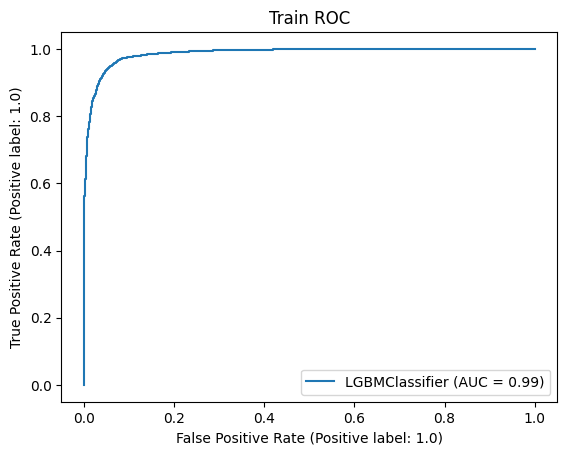

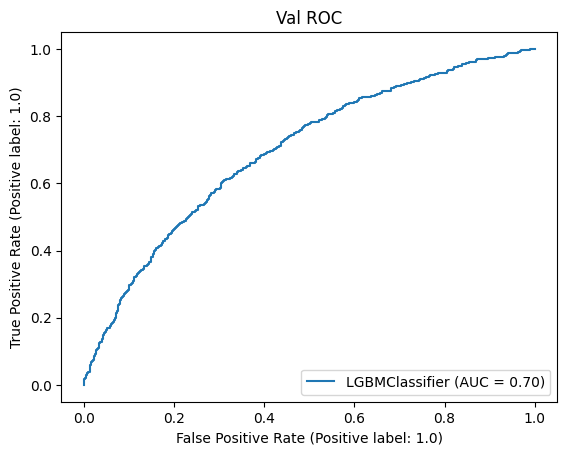

In [20]:
RocCurveDisplay.from_estimator(model, X_train, y_train)
plt.title('Train ROC')
plt.show()
RocCurveDisplay.from_estimator(model, X_val, y_val)
plt.title('Val ROC')
plt.show()